In [1]:
pip install dowhy pandas numpy statsmodels matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Simulating Data
np.random.seed(42)

weeks = 100
df = pd.DataFrame({
    'week': np.arange(weeks),
    'price': np.random.uniform(8, 15, size=weeks),  # Random prices between $8 and $15
    'promotion': np.random.choice([0, 1], size=weeks, p=[0.7, 0.3]),  # 30% of weeks have a promotion
    'holiday': np.random.choice([0, 1], size=weeks, p=[0.8, 0.2]),  # 20% of weeks are holidays
    'seasonality': np.sin(np.linspace(0, 3 * np.pi, weeks))  # Seasonal trend
})

# Simulate sales with some noise and elasticity of price = -1.5
df['sales_units'] = (1000 * (df['price'] ** -1.5) 
                     + 200 * df['promotion'] 
                     + 100 * df['holiday']
                     + 300 * df['seasonality'] 
                     + np.random.normal(0, 50, size=weeks))

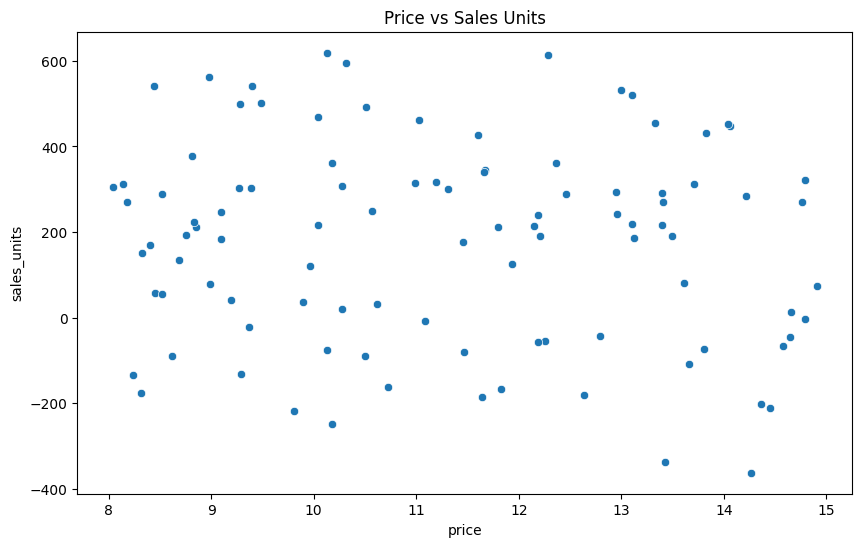

In [4]:
# Step 2: Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='sales_units', data=df)
plt.title('Price vs Sales Units')
plt.show()

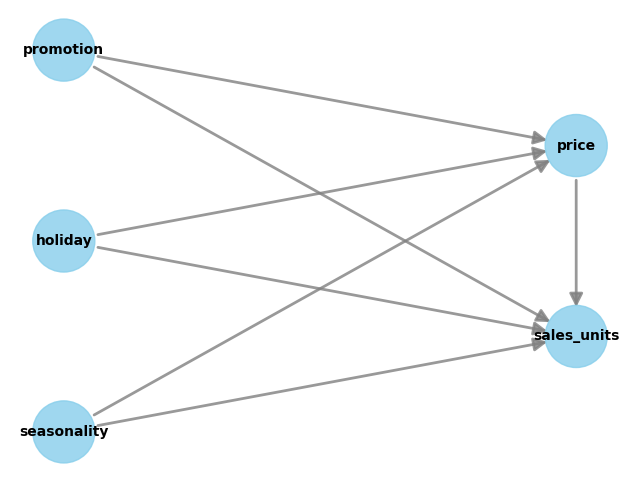

In [5]:
# Step 3: Building a Causal Model using DoWhy
# Define the causal graph: Price is the treatment, and sales_units is the outcome.
# Promotion, holiday, and seasonality are confounders.
causal_graph = """
digraph {
    price -> sales_units;
    promotion -> sales_units;
    holiday -> sales_units;
    seasonality -> sales_units;
    promotion -> price;
    holiday -> price;
    seasonality -> price;
}
"""

# Create a DoWhy CausalModel object
model = CausalModel(
    data=df,
    treatment='price',
    outcome='sales_units',
    graph=causal_graph
)

# View the causal graph
model.view_model()

In [6]:
# Step 4: Identify the Causal Effect
# DoWhy will automatically suggest an estimation method based on the data.
identified_estimand = model.identify_effect()

In [7]:
# Step 5: Estimate the Causal Effect using Regression
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

# Print the result
print("Causal Estimate: ", estimate.value)

Causal Estimate:  -0.16968608365570503


C:\Users\jimwa\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [10]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                  
────────(E[sales_units|holiday,promotion,seasonality])
d[price]                                              
Estimand assumption 1, Unconfoundedness: If U→{price} and U→sales_units then P(sales_units|price,holiday,promotion,seasonality,U) = P(sales_units|price,holiday,promotion,seasonality)

## Realized estimand
b: sales_units~price+holiday+promotion+seasonality
Target units: ate

## Estimate
Mean value: -0.16968608365570503



In [8]:
# Step 6: Refutation Testing (Checking Robustness of the Result)
# Refute the estimate by adding random confounders to check robustness
refutation = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(refutation)

C:\Users\jimwa\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\jimwa\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\jimwa\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is depr

Refute: Add a random common cause
Estimated effect:-0.16968608365570503
New effect:-0.17022705417248177
p value:0.96



C:\Users\jimwa\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\jimwa\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\jimwa\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is depr

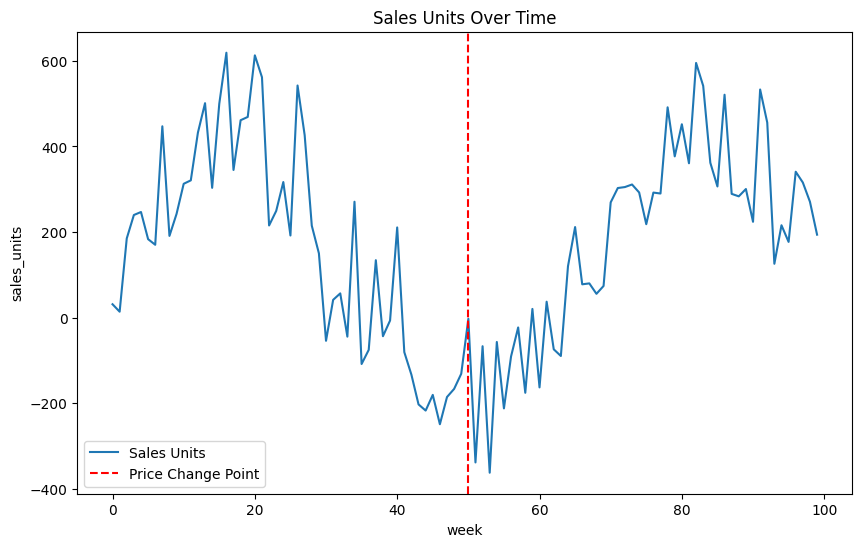

In [9]:
# Step 7: Visualize the Results
plt.figure(figsize=(10, 6))
sns.lineplot(x='week', y='sales_units', data=df, label='Sales Units')
plt.axvline(50, color='red', linestyle='--', label='Price Change Point')
plt.title('Sales Units Over Time')
plt.legend()
plt.show() 